# Patch Augmentation 

In this notebook we apply patch augmentation with randomly sized patches. 

The patches are of an a random area for each augmented image, between a minimum and maximum size defined by two parameters.

In this notebook we will train a ResNet20v1 network on the CIFAR-100 data set. 

First we make a number of imports:

In [1]:
# Define 100 or 10 here to select either the CIFAR-10 or CIFAR-100 data set
cifar = 100

import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
if cifar == 10:
    from keras.datasets import cifar10
elif cifar == 100:
    from keras.datasets import cifar100 
from keras.utils import Sequence

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
import random 
import os

%matplotlib inline

np.random.seed(0)

Using TensorFlow backend.


## Define the Patch Augmentation Class

Here we define the patch augmentation class:

In [2]:
class PatchAugmentation(Sequence):
    def __init__(self, batch_size, x, y, probability=1.0, min_patch_dimension=0.1, 
                 max_patch_dimension=0.9, image_area=1024):
        self.batch_size = batch_size
        self.x_train = x
        self.y_train = y
        self.probability = probability
        self.image_area = image_area
        self.min_patch_dimension = min_patch_dimension
        self.max_patch_dimension = max_patch_dimension
        
        self.dim = int(round(math.sqrt(self.image_area)))

    def __len__(self):
        return int(np.ceil(len(self.x_train) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        
        batch_x = np.copy(self.x_train[idx * self.batch_size:(idx+1) * self.batch_size])
        batch_y = np.copy(self.y_train[idx * self.batch_size:(idx+1) * self.batch_size])
        
        for i in range(len(batch_x)):
            
            if np.random.uniform(0, 1) <= self.probability:
                
                # Get the minimum width and maximum width of a patch
                min_width = round(self.min_patch_dimension * self.dim)
                max_width = round(self.max_patch_dimension * self.dim)
                
                # Get the minimum width and maximum width of a patch
                min_height = round(self.min_patch_dimension * self.dim)
                max_height = round(self.max_patch_dimension * self.dim)
                
                # Get the random patch dimensions, between min/max height and width
                horizontal_dim = np.random.randint(min_width, max_width+1)
                vertical_dim = np.random.randint(min_height, max_height+1)
                
                # Get a random location from where to take the patch
                # First, get the bounds where the patch can be taken 
                # (must be possible to extract this patch)
                x1 = np.random.randint(0, self.dim - horizontal_dim)
                y1 = np.random.randint(0, self.dim - vertical_dim)
                x2 = x1 + horizontal_dim
                y2 = y1 + vertical_dim
                 
                # Generate placement co-ordinates
                x1p = np.random.randint(0, self.dim - horizontal_dim)
                y1p = np.random.randint(0, self.dim - vertical_dim) 
                x2p = x1p + horizontal_dim
                y2p = y1p + vertical_dim
                
                # Get a random sample from the entire training set 
                # This means we could be taking from the same class!
                r_i = np.random.randint(0, len(self.x_train))
                
                batch_x[i][x1p:x2p, y1p:y2p, :] = self.x_train[r_i][x1:x2, y1:y2, :]
                                
                lambda_value = (horizontal_dim * vertical_dim) / (self.dim * self.dim)
                batch_y[i] = (1- lambda_value) * batch_y[i] + lambda_value * self.y_train[r_i]
            
        return batch_x, batch_y

## Visually Verify its Functionality

Here we load three sample images for the creation of a demonstration data set to visually verifiy that the `PatchAugmentation` class above functions as expected:

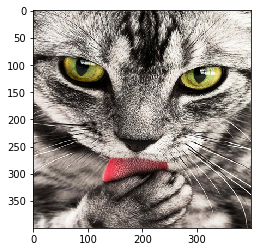

In [3]:
cat = Image.open('DemoImages/cat.jpg').resize((400,400), Image.LANCZOS)
dog = Image.open('DemoImages/dog.jpg').resize((400,400), Image.LANCZOS)
bird = Image.open('DemoImages/bird.jpg').resize((400,400), Image.LANCZOS)

cat = np.asarray(cat, dtype=np.uint16)
dog = np.asarray(dog, dtype=np.uint16)
bird = np.asarray(bird, dtype=np.uint16)
plt.imshow(cat);

Using these three images, we will create an example data set:

In [4]:
num_of_examples = 100
x_train_exp = np.empty((num_of_examples, 400, 400, 3), dtype=np.uint16)
y_train_exp = []

for i in range(0, num_of_examples):
    
    r = random.choice([0,1,2])
    
    if r == 0:
        x_train_exp[i,:,:,:] = cat
        y_train_exp.append([1.0, 0.0, 0.0]) 
    elif r == 1:
        x_train_exp[i,:,:,:] = dog
        y_train_exp.append([0.0, 1.0, 0.0])
    else: 
        x_train_exp[i,:,:,:] = bird
        y_train_exp.append([0.0, 0.0, 1.0])

y_train_exp = np.array(y_train_exp)

# Confirm some numbers
print("Image array shape: %s, length of label vector: %s" % (x_train_exp.shape, len(y_train_exp)))

cat_count, dog_count, bird_count = 0, 0, 0
for i in range(0, len(y_train_exp)):
    if np.argmax(y_train_exp[i]) == 0:
        cat_count += 1
    elif np.argmax(y_train_exp[i]) == 1:
        dog_count += 1
    else:
        bird_count += 1

print("Number of cats: %s, number of dogs: %s, number of birds: %s." % (cat_count, dog_count, bird_count))
assert (cat_count + dog_count + bird_count) == num_of_examples

Image array shape: (100, 400, 400, 3), length of label vector: 100
Number of cats: 33, number of dogs: 32, number of birds: 35.


We can view a random image from our newly created data set to verify it has been populated correctly:

Random index: 44
Label vector: [0. 1. 0.]


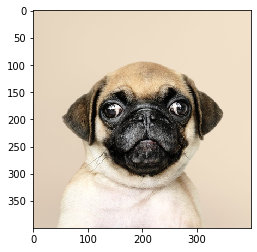

In [5]:
idx = np.random.randint(0, len(x_train_exp))
print("Random index: %s" % idx)
plt.imshow(x_train_exp[idx])
print("Label vector: %s" % y_train_exp[idx])

Now we create a generator based on this data set. 

Here we define the minimum and maximum dimensions for the patches when creating the `PatchAugmentation` object:

In [6]:
b_size = 100
m = PatchAugmentation(b_size, x=x_train_exp, y=y_train_exp, probability=1.0, 
                      min_patch_dimension=0.1, max_patch_dimension=0.9, image_area=400*400)

We will use `m` later in a Keras generator to pass image data to the network in batches.

Let us first look at a random batch to verify that the `PatchAugmentation` class is generating the data that we desire:

In [7]:
r_g = np.random.randint(0, len(m))
x, y = m.__getitem__(r_g)
print("Random batch index %s" % (r_g))

Random batch index 0


Now let's examine three random examples and verify their labels.

Remember that their labels are:

Cat is [1.0, 0.0, 0.0]

Dog is [0.0, 1.0, 0.0]

Bird is [0.0, 0.0, 1.0]

Index: 4, Batch: 0, Label vector: [0.57109375 0.         0.42890625]


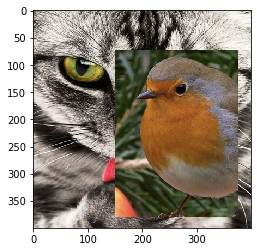

In [8]:
idex = np.random.randint(0, len(x))
print("Index: %s, Batch: %s, Label vector: %s" % (idex, r_g, y[idex]))
plt.imshow(x[idex]);

Index: 20, Batch: 0, Label vector: [0. 1. 0.]


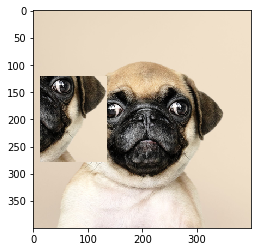

In [9]:
idex = np.random.randint(0, len(x))
print("Index: %s, Batch: %s, Label vector: %s" % (idex, r_g, y[idex]))
plt.imshow(x[idex]);

Index: 67, Batch: 0, Label vector: [0.88285 0.11715 0.     ]


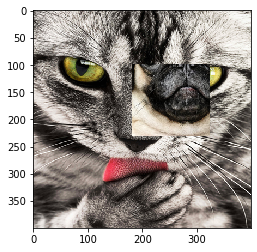

In [11]:
idex = np.random.randint(0, len(x))
print("Index: %s, Batch: %s, Label vector: %s" % (idex, r_g, y[idex]))
plt.imshow(x[idex]);

Remember the labels are:

Cat is [1.0, 0.0, 0.0]

Dog is [0.0, 1.0, 0.0]

Bird is [0.0, 0.0, 1.0]

## Train a Network Using Patch Augmentation

We will discard the example data set created above and now train a network, in this case ResNet20v1, on the CIFAR-1ß data set using patch augmentation.

The code used here to define ResNet v1 and v2 is from the Keras documentation, see <https://keras.io/>. 

We first define a scheduler call back function followed by a ResNet layer and the ResNet v1 and v2 model builders:

In [12]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 100, 140, 180, and 190 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 190: 
        lr *= 0.5e-3
    elif epoch > 180:  
        lr *= 1e-3
    elif epoch > 140: 
        lr *= 1e-2
    elif epoch > 100: 
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [13]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [14]:
def resnet_v1(input_shape, depth, num_classes=cifar):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
def resnet_v2(input_shape, depth, num_classes=cifar):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

Here we define some parameters, such as the depth of the network and whether to use version 1 or 2 of ResNet:

In [16]:
# Subtracting the pixel mean helps with the final accuracy. For all experiments we leave this as True.
subtract_pixel_mean = True

# Depth of the ResNet network can be defined here.
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

In [17]:
cifar_10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

cifar_100_labels = [
'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
'worm'
]

if cifar == 10:
    num_classes = len(cifar_10_labels)
elif cifar == 100:
    num_classes = len(cifar_100_labels)

if cifar == 10:
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
elif cifar == 100:
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

input_shape = x_train.shape[1:]

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

In [18]:
# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])

save_dir = os.path.join('/tmp/', 'saved_models')
model_name = 'cifar%s_%s_model.{epoch:03d}.h5' % (cifar, model_type)

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)


callbacks = [lr_reducer, lr_scheduler]  # Add checkpoint to this list to save model file

print(model_type)

Learning rate:  0.001
ResNet20v1


In [19]:
patch_swap_generator = PatchAugmentation(batch_size=128, x=x_train, y=y_train, 
                                         probability=0.9, min_patch_dimension=0.3, 
                                         max_patch_dimension=0.8, image_area=32*32)

In [20]:
history = model.fit_generator(patch_swap_generator, 
                              epochs=200, 
                              validation_data=(x_test, y_test), 
                              shuffle=True, 
                              callbacks=callbacks, 
                              verbose=1)

Epoch 1/200
Learning rate:  0.001
391/391 [==============================] - 29s 75ms/step - loss: 4.5168 - acc: 0.0633 - val_loss: 4.0142 - val_acc: 0.1052
Epoch 2/200
Learning rate:  0.001
391/391 [==============================] - 22s 55ms/step - loss: 4.1725 - acc: 0.1125 - val_loss: 3.8018 - val_acc: 0.1446
Epoch 3/200
Learning rate:  0.001
391/391 [==============================] - 22s 56ms/step - loss: 4.0425 - acc: 0.1385 - val_loss: 3.5726 - val_acc: 0.1840
Epoch 4/200
Learning rate:  0.001
391/391 [==============================] - 22s 56ms/step - loss: 3.9213 - acc: 0.1640 - val_loss: 3.2119 - val_acc: 0.2436
Epoch 5/200
Learning rate:  0.001
391/391 [==============================] - 22s 56ms/step - loss: 3.8256 - acc: 0.1855 - val_loss: 3.1576 - val_acc: 0.2626
Epoch 6/200
Learning rate:  0.001
391/391 [==============================] - 22s 57ms/step - loss: 3.7427 - acc: 0.2039 - val_loss: 3.1143 - val_acc: 0.2689
Epoch 7/200
Learning rate:  0.001
391/391 [===============

Epoch 53/200
Learning rate:  0.001
391/391 [==============================] - 22s 56ms/step - loss: 2.9142 - acc: 0.4410 - val_loss: 2.0469 - val_acc: 0.5063
Epoch 54/200
Learning rate:  0.001
391/391 [==============================] - 22s 56ms/step - loss: 2.9132 - acc: 0.4371 - val_loss: 2.1369 - val_acc: 0.4759
Epoch 55/200
Learning rate:  0.001
391/391 [==============================] - 22s 56ms/step - loss: 2.9044 - acc: 0.4423 - val_loss: 2.1820 - val_acc: 0.4742
Epoch 56/200
Learning rate:  0.001
391/391 [==============================] - 22s 56ms/step - loss: 2.9029 - acc: 0.4410 - val_loss: 2.0909 - val_acc: 0.4946
Epoch 57/200
Learning rate:  0.001
391/391 [==============================] - 22s 55ms/step - loss: 2.9092 - acc: 0.4445 - val_loss: 1.9532 - val_acc: 0.5260
Epoch 58/200
Learning rate:  0.001
391/391 [==============================] - 22s 57ms/step - loss: 2.9010 - acc: 0.4463 - val_loss: 2.0319 - val_acc: 0.5124
Epoch 59/200
Learning rate:  0.001
391/391 [========

Epoch 105/200
Learning rate:  0.0001
391/391 [==============================] - 24s 61ms/step - loss: 2.6127 - acc: 0.5458 - val_loss: 1.6243 - val_acc: 0.6091
Epoch 106/200
Learning rate:  0.0001
391/391 [==============================] - 24s 61ms/step - loss: 2.6066 - acc: 0.5484 - val_loss: 1.6308 - val_acc: 0.6094
Epoch 107/200
Learning rate:  0.0001
391/391 [==============================] - 24s 61ms/step - loss: 2.6013 - acc: 0.5461 - val_loss: 1.6246 - val_acc: 0.6110
Epoch 108/200
Learning rate:  0.0001
391/391 [==============================] - 22s 57ms/step - loss: 2.5911 - acc: 0.5551 - val_loss: 1.6272 - val_acc: 0.6117
Epoch 109/200
Learning rate:  0.0001
391/391 [==============================] - 22s 57ms/step - loss: 2.5836 - acc: 0.5569 - val_loss: 1.6199 - val_acc: 0.6110
Epoch 110/200
Learning rate:  0.0001
391/391 [==============================] - 22s 55ms/step - loss: 2.5873 - acc: 0.5506 - val_loss: 1.6155 - val_acc: 0.6109
Epoch 111/200
Learning rate:  0.0001
391

391/391 [==============================] - 22s 55ms/step - loss: 2.4696 - acc: 0.5917 - val_loss: 1.6047 - val_acc: 0.6125
Epoch 157/200
Learning rate:  1e-05
391/391 [==============================] - 22s 57ms/step - loss: 2.4665 - acc: 0.5919 - val_loss: 1.6054 - val_acc: 0.6139
Epoch 158/200
Learning rate:  1e-05
391/391 [==============================] - 22s 56ms/step - loss: 2.4682 - acc: 0.5907 - val_loss: 1.6088 - val_acc: 0.6113
Epoch 159/200
Learning rate:  1e-05
391/391 [==============================] - 22s 56ms/step - loss: 2.4643 - acc: 0.5881 - val_loss: 1.6066 - val_acc: 0.6105
Epoch 160/200
Learning rate:  1e-05
391/391 [==============================] - 22s 55ms/step - loss: 2.4709 - acc: 0.5893 - val_loss: 1.6059 - val_acc: 0.6098
Epoch 161/200
Learning rate:  1e-05
391/391 [==============================] - 22s 56ms/step - loss: 2.4659 - acc: 0.5879 - val_loss: 1.6040 - val_acc: 0.6131
Epoch 162/200
Learning rate:  1e-05
391/391 [==============================] - 22s

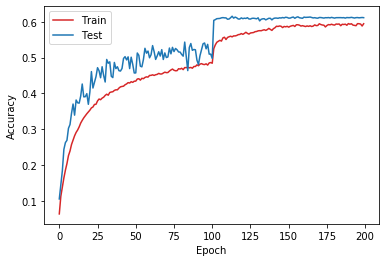

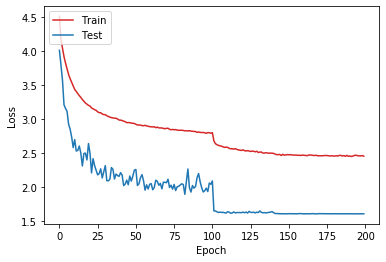

In [21]:
# Plot Accuracy
acc_peak = np.max(history.history['val_acc'])
plt.plot(history.history['acc'], color='tab:red')
plt.plot(history.history['val_acc'], color='tab:blue')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], color='tab:red')
plt.plot(history.history['val_loss'], color='tab:blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [38]:
print("Model trained with patch augmentation accuracy on test set: %.2f%%" % 
      (np.max(history.history['val_acc'])*100))

Model trained with patch augmentation accuracy on test set: 61.55%


This compares favourably to the baseline measurement of approximately 45%.